In [10]:
import os, platform, pprint, sys
import fastai
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sdv
import sklearn
import yellowbrick as yb

from fastai.tabular.data import TabularDataLoaders, TabularPandas
from fastai.tabular.all import FillMissing, Categorify, Normalize, tabular_learner, accuracy, ClassificationInterpretation, ShowGraphCallback, RandomSplitter, range_of

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.model_selection import CVScores, LearningCurve, ValidationCurve


seed: int = 14


# set up pretty printer for easier data evaluation
pretty = pprint.PrettyPrinter(indent=4, width=30).pprint

# set up pandas display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# declare file paths for the data we will be working on
file_path_1: str = '../../../data/original/Darknet.csv'
dataPath   : str = './models'


# print library and python versions for reproducibility
print(
    f'''
    python:\t{platform.python_version()}

    \tfastai:\t\t{fastai.__version__}
    \tmatplotlib:\t{mpl.__version__}
    \tnumpy:\t\t{np.__version__}
    \tpandas:\t\t{pd.__version__}
    \tsdv:\t\t{sdv.__version__}
    \tsklearn:\t{sklearn.__version__}
    \tyellowbrick:\t{yb.__version__}
    '''
)


    python:	3.7.10

    	fastai:		2.4.1
    	matplotlib:	3.3.4
    	numpy:		1.20.3
    	pandas:		1.2.5
    	sdv:		0.13.1
    	sklearn:	1.0.2
    	yellowbrick:	1.3.post1
    


In [21]:
def load_data(filePath: str) -> pd.DataFrame:
    '''
        Loads the Dataset from the given filepath and caches it for quick access in the future
        Function will only work when filepath is a .csv file
    '''

    # slice off the ./CSV/ from the filePath
    if filePath[0] == '.' and filePath[1] == '.':
        filePathClean: str = filePath[23::]
        pickleDump: str = f'../../../data/cache/{filePathClean}.pickle'
    else:
        pickleDump: str = f'../../../data/cache/{filePath}.pickle'
    
    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}\n')
    
    # check if data already exists within cache
    # if not, load data and cache it
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(filePath, low_memory=True)
        df.to_pickle(pickleDump)
    
    return df


class SklearnWrapper(BaseEstimator):
    '''
        A wrapper for fastai learners for creating visualizations using yellowbrick
        code sourced from: 
        forums.fast.ai/t/fastai-with-yellowbrics-how-to-get-roc-curves-more/79408
    '''
    _estimator_type = "classifier"
        
    def __init__(self, model):
        self.model = model
        self.classes_ = list(self.model.dls.y.unique())
    
    def fit(self, X, y):
        pass
        
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
    
    def get_new_preds(self, X):
        new_to = self.model.dls.valid_ds.new(X)
        new_to.conts = new_to.conts.astype(np.float32)
        new_dl = self.model.dls.valid.new(new_to)
        with self.model.no_bar():
            preds,_,dec_preds = self.model.get_preds(dl=new_dl, with_decoded=True)
        return (preds, dec_preds)

    def predict_proba(self, X):
        return self.get_new_preds(X)[0].numpy()
    
    def predict(self, X):
        return self.get_new_preds(X)[1].numpy()

In [22]:
df : pd.DataFrame = load_data(file_path_1)

Loading Dataset: ../../../data/original/Darknet.csv
	To Dataset Cache: ../../../data/cache/Darknet.csv.pickle



In [41]:
def run_experiment(df: pd.DataFrame, name: str) -> tuple:
    '''
        Run binary classification on a given dataframe, saving the model as {name}.model
        returns the 7-tuple with the following indicies:
        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    # dep_var: str = 'Label'
    dep_var: str = 'Label'

    # trim: list = [
    #     'Flow ID',
    #     'Src IP',
    #     'Dst IP',
    #     'Src Port',
    #     'Dst Port',
    #     'Timestamp',
    #     'Label1'
    # ]

    # now we remove the features in trim from the dataframe
    # df = df.drop(trim, axis=1)


    categorical_features: list = []

    print(df.shape)

    # if 'Protocol' in df.columns:
    #     categorical_features.append("Protocol")
        
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]))

    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    splits = RandomSplitter(valid_pct=0.2, seed=seed)(range_of(df))
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=64)

    # Next, we set up, train, and save the deep neural network
    model = tabular_learner(dls, layers=[50, 28], metrics=accuracy, cbs=ShowGraphCallback)
    model.fit_one_cycle(10)
    model.save(f'{name}.model')

    # We print the results of the training    
    loss, acc = model.validate()
    print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

    # A confusion matrix is created to help evaluate the results
    interp = ClassificationInterpretation.from_learner(model)
    interp.plot_confusion_matrix()

    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    # We wrap our model to make it look like a scikitlearn model
    # for visualization using yellowbrick
    wrapped_model = SklearnWrapper(model)

    # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    classes = list(model.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    # Now that the classifier has been created and trained, we pass out our training values
    # so that yellowbrick can use them to create various visualizations
    viz_data: tuple = (name, wrapped_model, classes, X_train, y_train, X_test, y_test)

    return viz_data


def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    '''
        Function will take a dataframe and remove the values from prune 
        Inf values will also be removed from Flow Bytes/s and Flow Packets/s
        once appropriate rows and columns have been removed, we will return
        the dataframe with the appropriate values
    '''
    prune: list = [
        'Flow ID',
        'Src IP',
        'Dst IP',
        'Src Port',
        'Dst Port',
        'Timestamp',
        'Label1'
    ]


    # remove the features in the prune list    
    for col in prune:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
            
    
    # drop missing values/NaN etc.
    df.dropna(inplace=True)

    
    # Search through dataframe for any Infinite or NaN values in various forms that were not picked up previously
    invalid_values: list = [
        np.inf, np.nan, 'Infinity', 'inf', 'NaN', 'nan'
    ]
    
    for col in df.columns:
        for value in invalid_values:
            indexNames = df[df[col] == value].index
            if not indexNames.empty:
                print(f'deleting {len(indexNames)} rows with Infinity in column {col}')
                df.drop(indexNames, inplace=True)


    # Standardize the contents of the Label column
    # df = df.replace( ['DrDoS_DNS'], 'DNS')
    # df = df.replace( ['DrDoS_LDAP'], 'LDAP')
    # df = df.replace( ['DrDoS_MSSQL'], 'MSSQL')
    # df = df.replace( ['DrDoS_NetBIOS'], 'NetBIOS')
    # df = df.replace( ['DrDoS_NTP'], 'NTP')
    # df = df.replace( ['DrDoS_SNMP'], 'SNMP')
    # df = df.replace( ['DrDoS_SSDP'], 'SSDP')
    # df = df.replace( ['DrDoS_UDP'], 'UDP')
    # df = df.replace( ['UDP-lag'], 'UDPLag')

    
    return df



def visualize_confusion_matrix(viz_data: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a confusion matrix

        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ConfusionMatrix(viz_data[1], classes=viz_data[2], title=viz_data[0])
    visualizer.score(viz_data[5], viz_data[6])
    visualizer.show()


def visualize_roc(viz_data: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a 
        Receiver Operating Characteristic (ROC) Curve

        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ROCAUC(viz_data[1], classes=viz_data[2], title=viz_data[0])
    visualizer.score(viz_data[5], viz_data[6])
    visualizer.poof()


def visualize_pr_curve(viz_data: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a 
        Precision-Recall Curve

        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.PrecisionRecallCurve(viz_data[1], title=viz_data[0])
    visualizer.score(viz_data[5], viz_data[6])
    visualizer.poof()


def visualize_report(viz_data: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a report
        detailing the Precision, Recall, f1, and Support scores for all 
        classification outcomes

        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ClassificationReport(viz_data[1], classes=viz_data[2], title=viz_data[0], support=True)
    visualizer.score(viz_data[5], viz_data[6])
    visualizer.poof()


def visualize_class_balance(viz_data: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a histogram
        detailing the balance between classification outcomes

        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.target.ClassBalance(labels=viz_data[0])
    visualizer.fit(viz_data[4], viz_data[6])
    visualizer.show()

In [42]:
df = clean_data(df)

deleting 2 rows with Infinity in column Flow Bytes/s


(141530, 78)


epoch,train_loss,valid_loss,accuracy,time
0,nan,nan,0.661238,00:17
1,nan,nan,0.661238,00:16
2,nan,nan,0.661238,00:16
3,nan,nan,0.661238,00:17
4,nan,nan,0.661238,00:16
5,nan,nan,0.661238,00:16


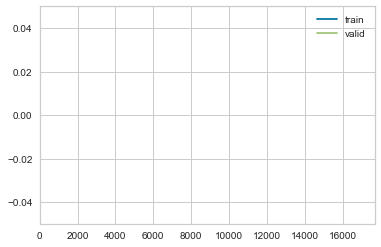

KeyboardInterrupt: 

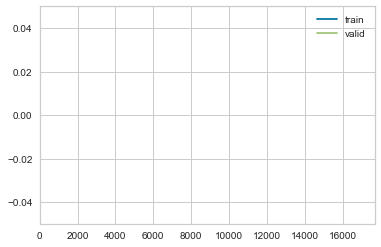

In [40]:
results = run_experiment(df, 'ddos_vs_benign_baseline')

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


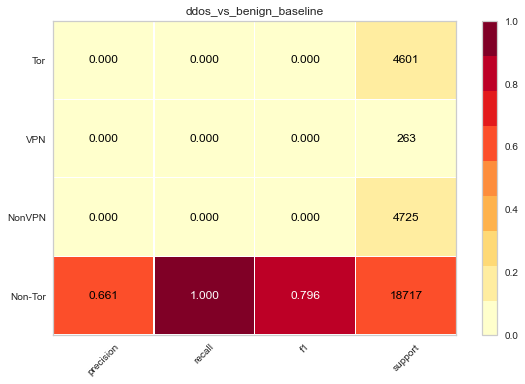

In [ ]:
visualize_report(results)

In [32]:
visualize_roc(results)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


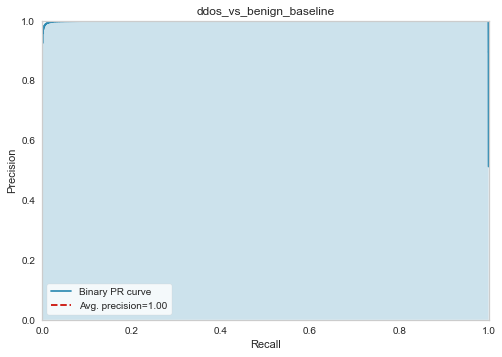

In [ ]:
visualize_pr_curve(results)